In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from connalysis.network import stats as nstats
import conntility
import sys
sys.path.append('../../../library')
from structural_basic import *

In [2]:
# Load connectivity data 
conn="BBP"
connectome=load_connectome("../../data", conn)

# Load activity data 
activity_dims=pd.read_pickle("/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_signals.pkl")
dim_frac=(activity_dims["actitivy_dimension"]/activity_dims["active_ts"]).astype(float)
root_sim="/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA_Baseline"
rel_path=f'{root_sim}/working_dir/reliability_basic.npz'
rels=pd.Series(np.load(rel_path)['reliability'])

# Average across simplices filtering by layers (this is quick so we compute on the fly)  
layers=['234', 5, 6]
stats_activity_per_layer={layer:{"all":{conn:{}}, "maximal":{conn:{}}} for layer in layers}
for stype in stats_activity_per_layer[6].keys(): 
    # Load precomputed structural properties 
    if stype =="all":
                s_lists=pd.read_pickle(f"../../data/{conn}_list_simplices_by_dimension_.pkl")['original']
    elif stype =="maximal":
         s_lists=pd.read_pickle(f"../../data/{conn}_list_simplices_by_dimension_maximal.pkl")['original'] 
    # Average dimensionality
    for activity_param in ["Efficiency", "Reliability"]: 
        for layer in layers:
            vals=dim_frac.copy() if activity_param =="Efficiency" else rels.copy()
            # Filter by layer group
            if layer == 6 or layer == 5:
                vals[connectome.vertices["layer"]!=layer]=np.nan
            else:
                vals[connectome.vertices["layer"]==6]=np.nan
                vals[connectome.vertices["layer"]==5]=np.nan
            stats_activity_per_layer[layer][stype][conn][activity_param]=nstats.node_stats_per_position(s_lists,
                                                                                                        vals,
                                                                                                        dims=s_lists.index.drop(0),
                                                                                                        with_multiplicity=True)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.39s/it]


In [3]:
# Reformat data
def agg_along_dims(stats_dict, stype, conn, prop): 
    dims=stats_dict[stype][conn][prop].keys()
    df={"all":{}, "sink":{}, "source":{}}
    for dim in dims: 
        mean=stats_dict[stype][conn][prop][dim]["mean"]
        err=stats_dict[stype][conn][prop][dim]["sem"]
        df['all'][dim]=[mean.loc["all"], err.loc["all"]]
        df['source'][dim]=[mean.iloc[0], err.iloc[0]]
        df['sink'][dim]=[mean.iloc[-2], err.iloc[-2]]
    
    df={key:pd.DataFrame.from_dict(df[key], orient="index", columns=["mean", "sem"]) 
                                for key in df.keys()}
    return df
stats_BBP_per_layer={layer:{"all":{}, "maximal":{}} for layer in layers}
for stype in ["all", "maximal"]: 
    for prop in ["Efficiency", "Reliability"]:
        for layer in layers:
            stats_BBP_per_layer[layer][stype][prop]=agg_along_dims(stats_activity_per_layer[layer], stype, conn, prop) 
   

### Plotting 

In [4]:
def plot_and_fill(ax, data, label, color, ms, marker, alpha): 
    ax.plot(df["mean"], marker=marker, label=label, ms=ms)
    ax.fill_between(data.index, data["mean"]-data["sem"], data["mean"]+data["sem"], alpha=alpha)

# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=4
conversion=2.54
#conversion=1.5
linewidth=2; 

colors={"all":"C0",
       "sink": "C1",
       "source":"C2"}
markers={"all":"o",
       "sink": ">",
       "source":"<"}
ms=2
alpha=0.25

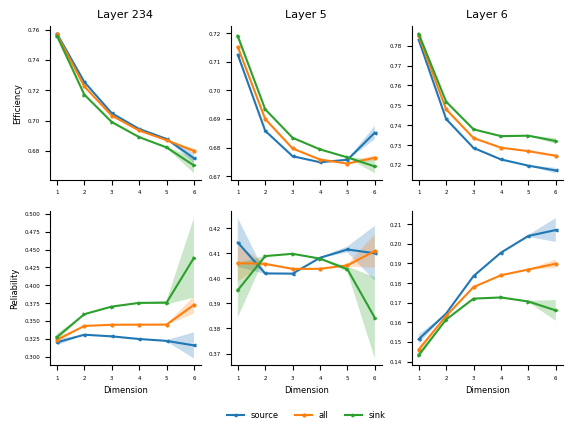

In [5]:
width=21*0.8/conversion

rows=2; cols=3
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows/cols), sharex=False, sharey=False)
# Efficiency and reliability across simplices 
stype="maximal" #"all"
for j, l in enumerate(layers):
    axs[0,j].set_title(f"Layer {l}", fontsize=titlesize)
    for i, prop in enumerate(["Efficiency", "Reliability"]):
        for pos in ["source", "all", "sink"]:  
            df=stats_BBP_per_layer[l][stype][prop][pos]
            plot_and_fill(axs[i,j], df, pos, colors[pos], ms, markers[pos], alpha=alpha)
            
        axs[i,j].spines[["top", "right"]].set_visible(False)
        axs[i,0].set_ylabel(prop, fontsize=labelsize)
        axs[1,j].set_xlabel("Dimension", fontsize=labelsize)

axs[1,1].legend(frameon=False, fontsize=labelsize, ncol=3,loc=8, bbox_to_anchor=(0.5,-0.40) )
#fig.savefig(f"temp_figs/efficiency_reliab_dimension_layer_{l}.pdf", transparent=True, bbox_inches="tight")

for ax in axs.flatten(): 
    ax.tick_params(axis='both', labelsize=ticksize)


fig.savefig("figs/reliability_effiency_and_structure_panels_only.pdf", transparent=True, bbox_inches='tight')